# Plots for PicoScope analysis

## Preliminary operations

### Paths

In [1]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "plots/data/picoscope/"
SAVE_PATH = USER_PATH + "plots/plots/"

### Flags

In [2]:
UNZIP_DATA    = False
WAVE2NUMPY    = False
PLOT_WAVE     = False
PLOT_MAV_WAVE = False
REJECT_3SIGMA = False

### Load packages

In [3]:
import os
import ROOT
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

Welcome to JupyROOT 6.22/06


In [4]:
from scipy import stats
from ROOT import TF1
from ROOT import TCanvas, TGraph, TGraphErrors

### Settings

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [6]:
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

<ipython-input-6-4c3d034b1475>:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


In [7]:
col = palette.brewer['RdYlGn'][10]

### Constants

In [8]:
MIN_MV   = 2400
MAX_MV   = 3500
BKG_RATE = 0.2951674822029528 #6.635    # ev/h

### Functions

In [9]:
def moving_average(x, M):
    return np.convolve(x, np.ones(M), 'valid') / M

***

<br>
<br>
<br>
<br>
<br>

***

## Preliminary plots: test run at `33_SC`

### Load data

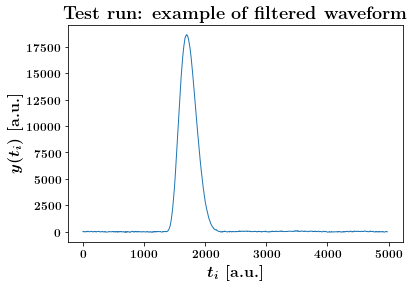

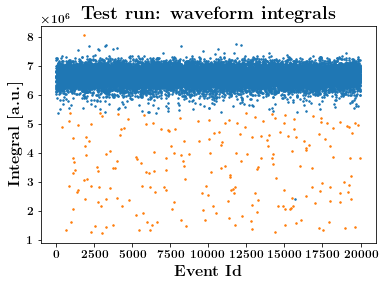

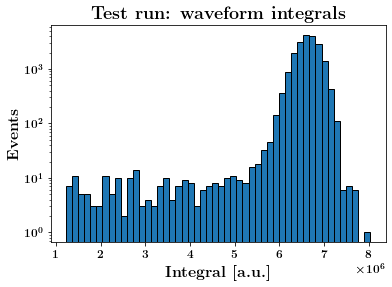

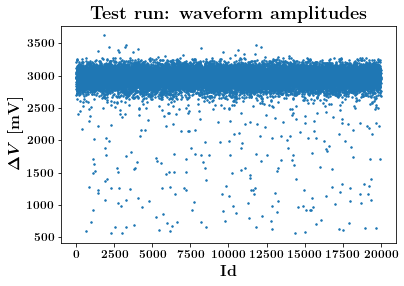

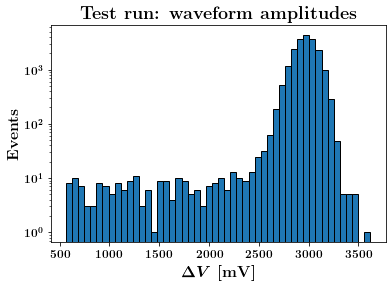

In [10]:
M  = 20
SC = 33

angles = []
events = []
err_angles = []
err_events = []

pico_step = []
pico_rad  = []
pico_deg  = []
pico_seg  = []
pico_ev   = []
pico_t    = []
pico_r    = []

pico_step_err = []
pico_rad_err  = []
pico_deg_err  = []
pico_ev_err   = []
pico_r_err    = []



os.chdir(USER_PATH + "data/beam_profile_long_101220/")
for d in os.listdir("."):
    if d=="33_1_SC":
        os.chdir(d)
        run = d.split("_")[0]

        #######################################################################
        # TAKE DIRECTION FROM DIR NAME
        #######################################################################
        if "DC" in d:
            sign = -1
        elif "SC" in d:
            sign = +1
        else:
            sign = 0
        #######################################################################

        #######################################################################
        # TAKE DATA FROM run FILE
        #######################################################################
        file = open("run")
        line = file.readlines()
        for l in line:
            if (l.startswith("n_segments")):
                n_seg = int(l.split('=')[1].strip())
                pico_seg.append(n_seg)
            if (l.startswith("run_time")):
                run_time = int(l.split('=')[1].strip())
        file.close()

        steps = sign * int(''.join(filter(lambda i: i.isdigit(), run))) - SC
        #######################################################################

        #######################################################################
        # TAKE DATA FROM run_BlockTimes.txt
        #######################################################################
        times  = np.loadtxt("run_BlockTimes.txt")
        blocks = times.shape[0]
        events = blocks * n_seg
        # print(times.shape)
        if times.shape != (2,):
            t  = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])
        else:
            t  = run_time
        #######################################################################


        #######################################################################
        # TAKE DATA FROM ALL WAVEFORMS
        #######################################################################
        # load data and smooth filter with MAV
        data     = np.load(d+".npy")
        data_mav = np.apply_along_axis(moving_average, 1, data, M)

        # compute baseline mask
        baseline_mask = np.arange(data_mav.shape[1])
        baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

        # compute baseline and amplitude
        baseline   = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]
        peaks      = np.max(data_mav, axis=1)
        amplitudes = (peaks - baseline) * 10 / 65536 * 1000
        
        # mask for amplitudes
        mask = (amplitudes>=MIN_MV) & (amplitudes<=MAX_MV)

        # filter events by waveform amplitude
        events = amplitudes[(amplitudes>=MIN_MV) & (amplitudes<=MAX_MV)].shape[0]

        # compute integral
        data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]
        _            = data_mav_int<1.0e7
        data_mav_int = data_mav_int[_]
        amplitudes   = amplitudes[_]
        mask         = mask[_]

        # plot waveforms
        fig = plt.figure(figsize=(6, 4))
        plt.plot(np.arange(data_mav[0].shape[0]), data_mav[0,:], "-", linewidth=1.0)
        plt.xlabel(r"\bf{$t_{i}$ [a.u.]}")
        plt.ylabel(r"\bf{$y(t_{i})$ [a.u.]}")
        plt.title(r"\bf{Test run: example of filtered waveform}")
        fig.savefig(SAVE_PATH + "picoscope/test_run_waveform.pdf", bbox_inches='tight')
        plt.show()
        
        # plot integrals
        fig = plt.figure(figsize=(6, 4))
        plt.plot(np.where(mask)[0], data_mav_int[mask], "o", markersize=1.5)
        plt.plot(np.where(np.logical_not(mask))[0], data_mav_int[np.logical_not(mask)], "o", markersize=1.5)
        plt.xlabel(r"\bf{Event Id}")
        plt.ylabel(r"\bf{Integral [a.u.]}") #$10^{6}\cdot$
        plt.title(r"\bf{Test run: waveform integrals}")
        plt.show()

        fig = plt.figure(figsize=(6, 4))
        plt.hist(data_mav_int, bins=50, edgecolor="black")
        plt.yscale("log")
        plt.xlabel(r"\bf{Integral [a.u.]}")
        plt.ylabel(r"\bf{Events}")
        plt.title(r"\bf{Test run: waveform integrals}")
        fig.savefig(SAVE_PATH + "picoscope/test_run_integrals.pdf", bbox_inches='tight')
        plt.show()

        # plot amplitudes
        fig = plt.figure(figsize=(6, 4))
        plt.plot(np.arange(amplitudes.shape[0]), amplitudes, "o", markersize=1.5)
        plt.xlabel(r"\bf{Id}")
        plt.ylabel(r"\bf{$\Delta V$ [mV]}")
        plt.title(r"\bf{Test run: waveform amplitudes}")
        plt.show()

        fig = plt.figure(figsize=(6, 4))
        plt.hist(amplitudes, bins=50, edgecolor="black")
        plt.yscale("log")
        plt.xlabel(r"\bf{$\Delta V$ [mV]}")
        plt.ylabel(r"\bf{Events}")
        plt.title(r"\bf{Test run: waveform amplitudes}")
        fig.savefig(SAVE_PATH + "picoscope/test_run_amplitudes.pdf", bbox_inches='tight')
        plt.show()
        #######################################################################


        #######################################################################
        # COMPUTE RELEVANT QUANTITIES
        #######################################################################
        pico_step.append(steps)
        pico_rad.append(steps * 0.9 * np.pi / 180.0)
        pico_deg.append(steps * 0.9)
        pico_t.append(t)
        pico_ev.append(events)
        pico_r.append(events / t * 3600)
        #######################################################################

        #######################################################################
        # COMPUTE ERRORS
        #######################################################################
        pico_step_err.append(0.05) # 1.0 / np.sqrt(12.0)
        pico_rad_err .append(0.05 * 0.9 * np.pi / 180.0)
        pico_deg_err .append(0.05 * 0.9)
        pico_ev_err  .append(np.sqrt(events))
        pico_r_err   .append(np.sqrt(events) / t * 3600)
        #######################################################################

        os.chdir(USER_PATH)

***

<br>
<br>
<br>
<br>
<br>

***

## $\alpha$ particle spectrum after source gold plate

### Constants

In [11]:
# general physical constants
c  = 3.0e8
e0 = 8.854e-12
e  = 1.602e-19
eA = 4.8 * 1e6 * e    # alpha energy in Joule

# atomic properties
m_p   = 938.272           # MeV/c^2
m_n   = 939.565           # MeV/c^2
m_a   = 2*m_p + 2*m_n
A_a   = 4
Z_a   = 2
Na    = 6.02214076e23     # particles/mol
alpha = 1.0/137.035999    # fine structure constant-


rho_Au    = 19.3 #g/cm^3
A_Au      = 196.997 #g/mol
Dat_Au    = np.power(rho_Au*Na/A_Au, -1/3)*0.01/(1000*(0.197e-15)) #gold inter atomic distance
th_Au     = 0.16e-6 #gold foild thickness
Z_Au      = 79
Z_Au_eff  = 67
R_Au      = 166e-3 #atomix radius in nanometers
lambda_Au = np.log(Z_Au/Z_Au_eff)/R_Au


x0_au = 196.3 # g/cm2

energies = np.array([5.48556, 5.44280, 5.3880 ])
frac     = np.array([0.848,  0.131,  0.0166])

stop_pow = 2.234 *1e2    # Mevcm2/g
x0_au    = 196.3         # g/cm2
th_layer = 1.510*1e-4

e_loss = stop_pow * rho_Au*th_layer

gamma = 1.0 + energies/(4*m_p)
beta  = np.sqrt(1 - 1/np.square(gamma))

me = 0.511
ma = 4*m_p

In [12]:
tmax = 2*me*np.square(gamma)*np.square(beta)/(1+2*gamma*me/ma+(me/ma)**2)

en_fin = energies - e_loss
sigma2 = 0.1534* (4/np.square(beta)) * (79/196)*rho_Au*1.510*1e-4*tmax*(1-np.square(beta)/2)
sigma  = np.sqrt(sigma2)

print("gamma", gamma) 
print("beta", beta) 
print("Tmax", tmax) 
print("K", e_loss/tmax)
print("en_fin ", en_fin)
print("sigma2 ", sigma2)
print("sigma  ", sigma )

gamma [1.00146161 1.00145022 1.00143562]
beta [0.05400767 0.05379722 0.0535263 ]
Tmax [0.0029889  0.00296559 0.00293571]
K [217.82386987 219.53639777 221.77086457]
en_fin  [4.83450538 4.79174538 4.73694538]
sigma2  [0.00073749 0.00073748 0.00073747]
sigma   [0.02715682 0.02715667 0.02715647]


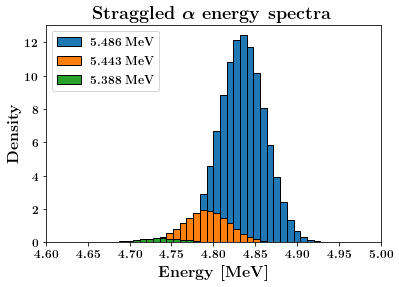

In [13]:
n_part = 10000000

yt = []
ee = []
ec = []
for i,f in enumerate(frac):
    ee.append(np.random.normal(en_fin[i], sigma[i], int(n_part*f)))
    yt += list(ee[-1])
    ec.append(int(n_part*f))
    
plt.figure(figsize=(6,4))
for i,f in enumerate(frac):
    plt.hist(ee[i], bins=50, weights=np.ones(ee[i].shape[0])/(sum(ec)*0.4/50), edgecolor='black', label=r"\bf{" + str(round(energies[i],3)) + r" MeV}", range=[4.6, 5])
    plt.xlim(4.6, 5)
    plt.xlabel(r"\bf{Energy [MeV]}")
    plt.ylabel(r"\bf{Density}")
plt.title(r"\bf{Straggled $\alpha$ energy spectra}")
plt.legend(fontsize=12, loc="upper left")
plt.savefig(SAVE_PATH + "source/source_straggled_channels.pdf", bbox_inches='tight')
plt.show()

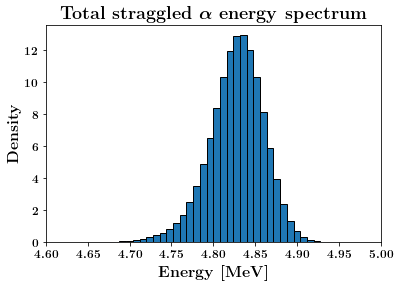

In [14]:
plt.figure(figsize=(6,4))
plt.hist(np.array(yt), bins=50, density =True, edgecolor='black', range=[4.6, 5])
plt.xlim(4.6, 5)
plt.xlabel(r"\bf{Energy [MeV]}")
plt.ylabel(r"\bf{Density}")
plt.title(r"\bf{Total straggled $\alpha$ energy spectrum}")
plt.savefig(SAVE_PATH + "source/source_straggled_total.pdf", bbox_inches='tight')
plt.show()

In [15]:
np.mean(np.array(yt))

4.827252082693751

In [16]:
np.std(np.array(yt)) / np.sqrt(np.array(yt).shape[0] - 1)

1.0436468723230054e-05

In [17]:
np.sqrt(np.sum(sigma2))

0.04703670107271746

***

<br>
<br>
<br>
<br>
<br>

***

## Isotropy plots

### Load data

In [18]:
df_exp = pd.read_csv(DATA_PATH + "pico_data_isotropy.csv")

In [19]:
df_exp = df_exp.append(
    pd.DataFrame(
        [[
            -40,
            -40 * 0.9 * np.pi/180.0,
            -40 * 0.9,
            100,
            10000,
            268.5,
            10000 / 267.5 * 3600,
            0.05,
            0.000785,
            0.045,
            100.0,
            np.sqrt(10000) / 267.5 * 3600
        ]],
        columns=df_exp.columns
    )
).sort_values("pico_step")

In [20]:
df_exp

,pico_step,pico_rad,pico_deg,pico_seg,pico_ev,pico_t,pico_r,pico_step_err,pico_rad_err,pico_deg_err,pico_ev_err,pico_r_err
0,-40,-0.628319,-36.0,100,10000,268.500000,134579.439252,0.05,0.000785,0.045,100.0,1345.794393
0,-30,-0.471239,-27.0,100,10000,262.809999,136981.089402,0.05,0.000785,0.045,100.0,1369.810894
1,-20,-0.314159,-18.0,100,10000,270.400000,133136.094628,0.05,0.000785,0.045,100.0,1331.360946
2,-10,-0.157080,-9.0,100,10000,264.640000,136033.857507,0.05,0.000785,0.045,100.0,1360.338575
3,0,0.000000,0.0,100,10000,264.710000,135997.884580,0.05,0.000785,0.045,100.0,1359.978846
4,10,0.157080,9.0,100,10000,264.500001,136105.859745,0.05,0.000785,0.045,100.0,1361.058597
5,20,0.314159,18.0,100,10000,265.430001,135628.979114,0.05,0.000785,0.045,100.0,1356.289791
6,30,0.471239,27.0,100,10000,270.320000,133175.495859,0.05,0.000785,0.045,100.0,1331.754959
7,40,0.628319,36.0,100,10000,267.030000,134816.312548,0.05,0.000785,0.045,100.0,1348.163125


### Compute weighted average

In [21]:
mean     = np.average(df_exp["pico_r"], weights=(1/np.square(df_exp["pico_r_err"])))
mean_std = 1 / np.sqrt(np.sum(1/np.square(df_exp["pico_r_err"])))

In [22]:
print("Weighted average:      ", mean)
print("Weighted average error:", mean_std)

Weighted average:       135137.8643272766
Weighted average error: 450.4794251231924


### Compute residues

In [23]:
res_num = mean - df_exp["pico_r"]
res_den = df_exp["pico_r_err"]
res     = res_num  / res_den

### Plot and save

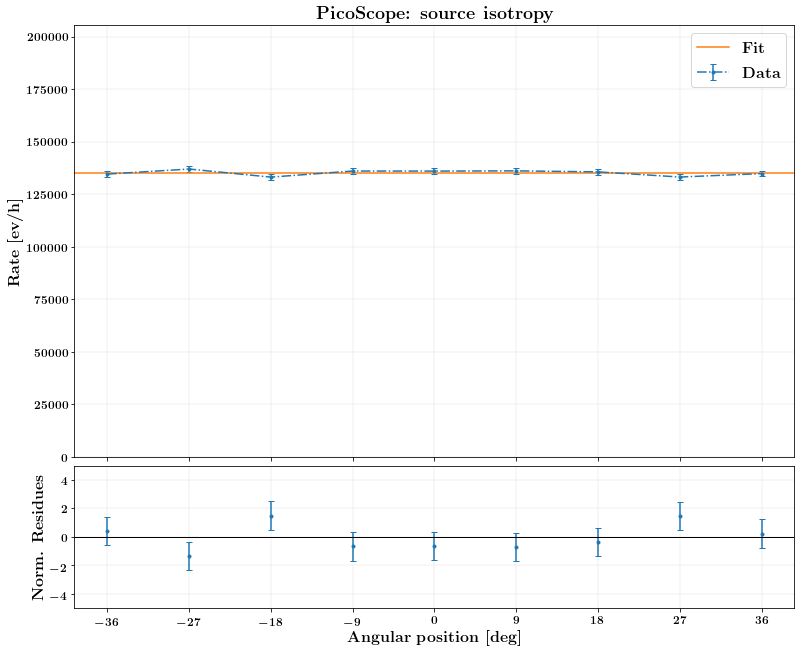

In [24]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["pico_deg"],
    y               = df_exp["pico_r"],
    yerr            = df_exp["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## PLOT OF WEIGHTED AVERAGE HLINE
plt.axhline(
    y         = mean,
    color     = "C1",
    linewidth = 1.5,
    label     = r"\bf{Fit}"
)

########## CHI2 / ndof
# plt.text(
#     0.98, 
#     0.02, 
#     r'$\frac{\chi^2}{\rm d.o.f.} = \frac{%.2f}{%2.0g}$' % (np.sum(np.square(res)), res.shape[0]),
#     ha='right',
#     va='bottom',
#     # transform=ax.transAxes
# )

########## TOP PANEL SETTINGS
plt.ylim(np.max(df_exp["pico_r"])*0.0, np.max(df_exp["pico_r"])*1.5)
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{PicoScope: source isotropy}")
# plt.xlim(-18,18)
plt.xticks(df_exp["pico_deg"][df_exp["pico_deg"] % 9 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_exp["pico_deg"],
    y               = res,
    # xerr            = df_sim["pico_step_err"],
    yerr            = np.ones(df_exp.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    # markerfacecolor = "red",
    # color           = "red",
    # ecolor          = "red",
    label           = r"\bf{Norm. Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.ylim(-5,5)
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [deg]}")
plt.xticks(df_exp["pico_deg"][df_exp["pico_deg"] % 9 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "source/source_isotropy.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

In [25]:
print("chi2:", np.sum(np.square(res)))
print("dofs:", res.shape[0] - 1)

chi2: 7.942309173992524
dofs: 8


***

<br>
<br>
<br>
<br>
<br>

***

## Energy-angle correlation plots

### Load data

In [26]:
df_exp = pd.read_csv(DATA_PATH + "pico_data_correlation.csv")

In [27]:
df_exp

,pico_step,pico_rad,pico_deg,pico_e_mu,pred_e_mu,pico_step_err,pico_rad_err,pico_deg_err,pico_e_mu_err
0,-40,-0.628319,-36.0,4.510000,4.503652,0.05,0.000785,0.045,0.003000
1,-30,-0.471239,-27.0,4.655414,4.653462,0.05,0.000785,0.045,0.003175
2,-20,-0.314159,-18.0,4.745905,4.747343,0.05,0.000785,0.045,0.002988
3,-10,-0.157080,-9.0,4.793016,4.800141,0.05,0.000785,0.045,0.002974
4,0,0.000000,0.0,4.827000,4.819153,0.05,0.000785,0.045,0.002844
5,10,0.157080,9.0,4.808050,4.806831,0.05,0.000785,0.045,0.002895
6,20,0.314159,18.0,4.758174,4.761597,0.05,0.000785,0.045,0.003102
7,30,0.471239,27.0,4.678585,4.677320,0.05,0.000785,0.045,0.003219
8,40,0.628319,36.0,4.540829,4.541124,0.05,0.000785,0.045,0.003649


### Compute residues

In [28]:
res_num = df_exp["pred_e_mu"] - df_exp["pico_e_mu"]
res_den = df_exp["pico_e_mu_err"]
res     = res_num  / res_den

### Fit line

In [29]:
pars = np.load(DATA_PATH + "pico_data_correlation_pars.npy")
cov  = np.load(DATA_PATH + "pico_data_correlation_cov.npy")

In [30]:
print("a =", pars[0], "+/-", np.sqrt(cov[0,0]))
print("b =", pars[1], "+/-", np.sqrt(cov[1,1]))
print("c =", pars[2]*0.9*np.pi/180.0, "+/-", np.sqrt(cov[2,2])*0.9*np.pi/180.0)

a = 6.075313080020941 +/- 0.030422476132344035
b = -1.2559866822864736 +/- 0.02842461199898237
c = 0.016604173881414892 +/- 0.0035928279888434184


In [31]:
x_fit = np.linspace(-40, 40, 10000, endpoint=True)
y_fit = pars[0] + pars[1]/np.cos((x_fit/0.9 - pars[2])*0.9*np.pi/180.0)

### Plot and save

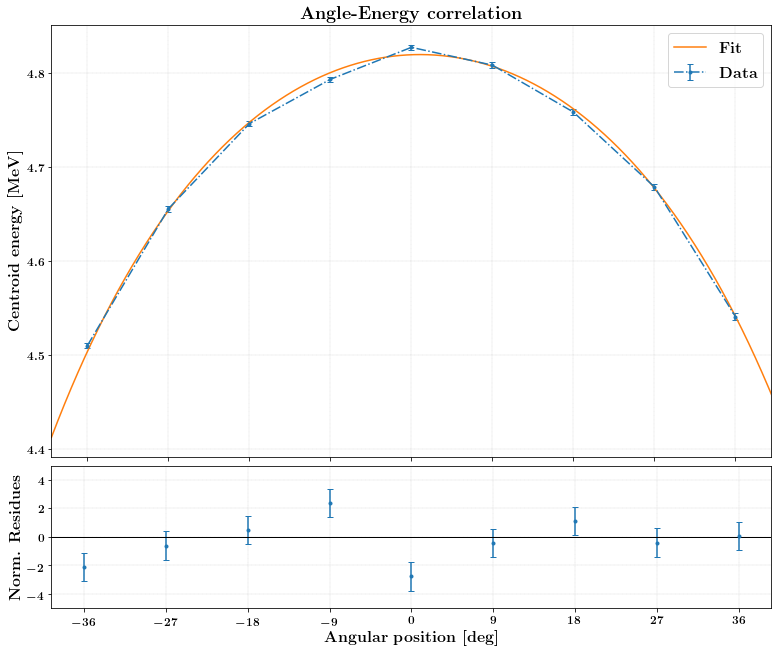

In [32]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["pico_deg"],
    y               = df_exp["pico_e_mu"],
    yerr            = df_exp["pico_e_mu_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## PLOT OF WEIGHTED AVERAGE HLINE
plt.plot(
    x_fit,
    y_fit,
    linewidth = 1.5,
    label     = r"\bf{Fit}"
)

########## TOP PANEL SETTINGS
# plt.ylim(np.max(df_exp["pico_r"])*0.0, np.max(df_exp["pico_r"])*1.5)
plt.ylabel(r"\bf{Centroid energy [MeV]}")
plt.title(r"\bf{Angle-Energy correlation}")
plt.xlim(-40,40)
plt.xticks(df_exp["pico_deg"][df_exp["pico_deg"] % 9 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_exp["pico_deg"],
    y               = res,
    # xerr            = df_sim["pico_step_err"],
    yerr            = np.ones(df_exp.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    # markerfacecolor = "red",
    # color           = "red",
    # ecolor          = "red",
    label           = r"\bf{Norm. Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.ylim(-5,5)
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [deg]}")
plt.xticks(df_exp["pico_deg"][df_exp["pico_deg"] % 9 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "source/source_correlation.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

In [33]:
print("chi2:", np.sum(np.square(res)))
print("dofs:", res.shape[0] - 3)

chi2: 19.99724780953076
dofs: 6


***

<br>
<br>
<br>
<br>
<br>

***

## Beam profile plots

### Load data

#### Experimental data

In [34]:
df_exp = pd.read_csv(DATA_PATH + "pico_data_profile.csv")

In [35]:
df_exp

,pico_step,pico_rad,pico_deg,pico_seg,pico_ev,pico_t,pico_r,pico_step_err,pico_rad_err,pico_deg_err,pico_ev_err,pico_r_err
0,-16,-0.251327,-14.4,1,1,1869.450000,1.925700,0.05,0.000785,0.045,1.000000,1.925700
1,-15,-0.235619,-13.5,1,7,1854.470000,13.588788,0.05,0.000785,0.045,2.645751,5.136079
2,-14,-0.219911,-12.6,1,379,1806.770000,755.159760,0.05,0.000785,0.045,19.467922,38.789951
3,-13,-0.204204,-11.7,1,1483,1800.020001,2965.967043,0.05,0.000785,0.045,38.509739,77.018622
4,-12,-0.188496,-10.8,100,5610,1829.810000,11037.211514,0.05,0.000785,0.045,74.899933,147.359431
5,-11,-0.172788,-9.9,100,8075,1811.340000,16048.891981,0.05,0.000785,0.045,89.861004,178.596847
6,-10,-0.157080,-9.0,100,10856,1801.790002,21690.430050,0.05,0.000785,0.045,104.192130,208.177240
7,-9,-0.141372,-8.1,100,13648,1806.259999,27201.399592,0.05,0.000785,0.045,116.824655,232.839546
8,-8,-0.125664,-7.2,100,16312,1801.070000,32604.618371,0.05,0.000785,0.045,127.718440,255.285128
9,-7,-0.109956,-6.3,100,19202,1808.079999,38232.379110,0.05,0.000785,0.045,138.571281,275.904060


#### Simulated data: load

In [36]:
df_sim = np.loadtxt(DATA_PATH + "pico_sim_profile.txt")

#### Simulated data: shift correction

In [37]:
shift       = np.average(df_exp["pico_step"], weights=df_exp["pico_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

#### Simulated data: grouping + normalization

In [38]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["pico_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["pico_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

#### Simulated data: put in dataframe

In [39]:
d_sim = {
    "pico_step"     : sim_steps,
    # "pico_rad"      : pico_rad,
    # "pico_deg"      : pico_deg,
    # "pico_seg"      : pico_seg,
    "pico_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "pico_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "pico_ev_err"   : np.sqrt(sim_ev),
    "pico_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['pico_step'])

### Subtract background

In [40]:
df_exp["pico_r"] = df_exp["pico_r"] - BKG_RATE

### Compute residues

In [41]:
res_num =                   df_sim["pico_r"]      -           df_exp["pico_r"]
res_den = np.sqrt(np.square(df_sim["pico_r_err"]) + np.square(df_exp["pico_r_err"]))
res     = res_num  / res_den

### Plot and save

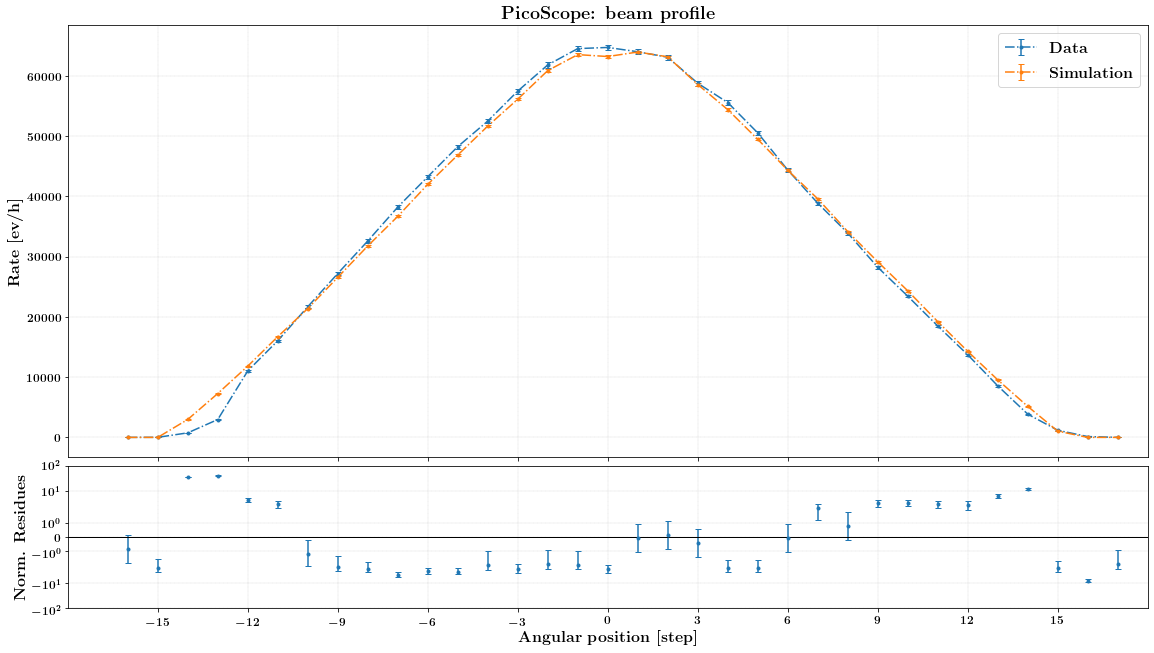

In [42]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["pico_step"],
    y               = df_exp["pico_r"],
    yerr            = df_exp["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["pico_step"],
    y               = df_sim["pico_r"],
    yerr            = df_sim["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{PicoScope: beam profile}")
plt.xlim(-18,18)
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 3 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["pico_step"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-18,18)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [step]}")
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 3 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "picoscope/beam_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

***

<br>
<br>
<br>
<br>
<br>

***

## Scattering profile plots

### Load data

#### Experimental data

In [43]:
df_exp = pd.read_csv(DATA_PATH + "pico_data_gold.csv")

In [44]:
df_exp

,pico_step,pico_rad,pico_deg,pico_seg,pico_step_err,pico_rad_err,pico_deg_err,pico_ev,pico_t,pico_r,pico_ev_err,pico_r_err
0,-60,-0.942478,-54.0,1,0.05,0.000785,0.045,49,174966.369999,1.008194,7.000000,0.144028
1,-50,-0.785398,-45.0,1,0.05,0.000785,0.045,45,133428.859999,1.214130,6.708204,0.180992
2,-40,-0.628319,-36.0,1,0.05,0.000785,0.045,38,86572.940000,1.580170,6.164414,0.256337
3,-35,-0.549779,-31.5,1,0.05,0.000785,0.045,41,43494.490000,3.393533,6.403124,0.529981
4,-30,-0.471239,-27.0,1,0.05,0.000785,0.045,19,18678.880000,3.661890,4.358899,0.840095
5,-28,-0.439823,-25.2,1,0.05,0.000785,0.045,44,18152.120000,8.726253,6.633250,1.315532
6,-26,-0.408407,-23.4,1,0.05,0.000785,0.045,51,18657.530000,9.840531,7.141428,1.377950
7,-24,-0.376991,-21.6,1,0.05,0.000785,0.045,50,10887.079999,16.533359,7.071068,2.338170
8,-22,-0.345575,-19.8,1,0.05,0.000785,0.045,58,10831.680000,19.276788,7.615773,2.531166
9,-20,-0.314159,-18.0,10,0.05,0.000785,0.045,85,7614.090000,40.188650,9.219544,4.359071


#### Simulated data: load

In [45]:
df_sim = np.loadtxt(DATA_PATH + "pico_sim_gold.txt")

#### Simulated data: shift correction

In [46]:
shift       = np.average(df_exp["pico_step"], weights=df_exp["pico_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

#### Simulated data: grouping + normalization

In [47]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["pico_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["pico_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

#### Simulated data: put in dataframe

In [48]:
d_sim = {
    "pico_step"     : sim_steps,
    # "pico_rad"      : pico_rad,
    # "pico_deg"      : pico_deg,
    # "pico_seg"      : pico_seg,
    "pico_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "pico_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "pico_ev_err"   : np.sqrt(sim_ev),
    "pico_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['pico_step'])

### Subtract background

In [49]:
df_exp["pico_r"] = df_exp["pico_r"] - BKG_RATE

### Compute residues

In [50]:
res_num =                   df_sim["pico_r"]      -           df_exp["pico_r"]
res_den = np.sqrt(np.square(df_sim["pico_r_err"]) + np.square(df_exp["pico_r_err"]))
res     = res_num  / res_den

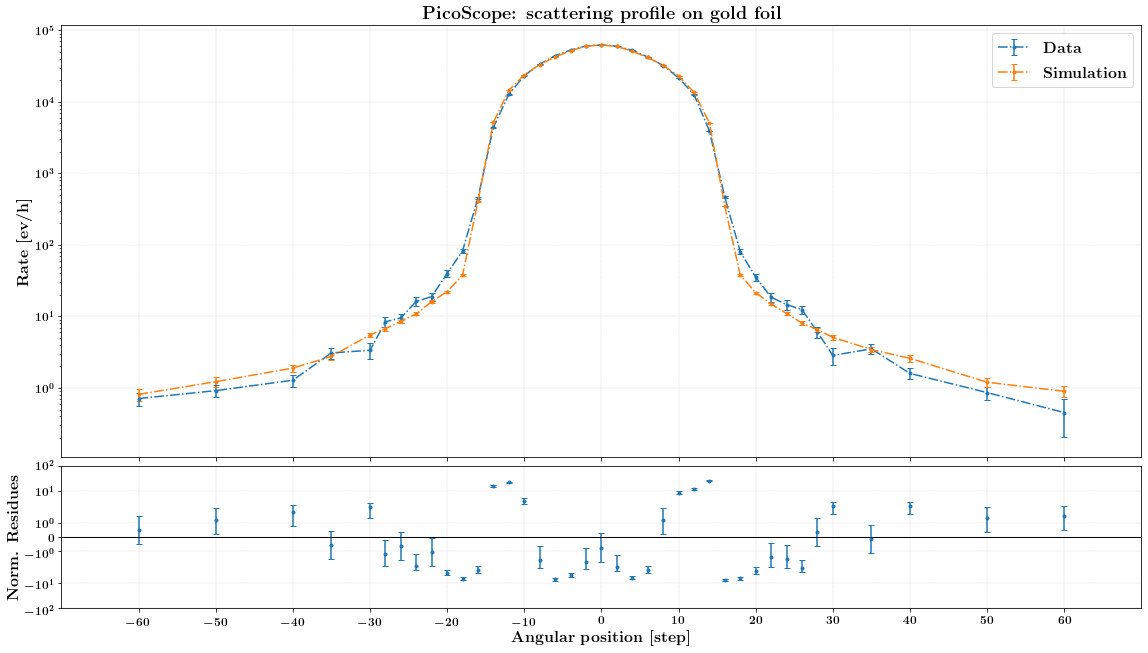

In [51]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["pico_step"],
    y               = df_exp["pico_r"],
    yerr            = df_exp["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["pico_step"],
    y               = df_sim["pico_r"],
    yerr            = df_sim["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.yscale("log")
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{PicoScope: scattering profile on gold foil}")
plt.xlim(-70,70)
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 10 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["pico_step"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-70,70)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [step]}")
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "picoscope/gold_scattering_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################